In [1]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [3]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[241]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000005)]
Operator(s) added to ansatz: [241]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [79]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float64(0.0)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710474288453)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926734934)]
Operator(s) added to ansatz: [210]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 210]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]

Current energy: -6.464101615134318
(change of -0.1368254603146104)
Current ansatz: [241, 79, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 2.9260899740755612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

I

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000036)]
Operator(s) added to ansatz: [216]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 216]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617644
(change of -0.12310562561763838)
Current ansatz: [241, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200767302
Operators under consideration (1):
[99]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710481676668)]
Operator(s) added to ansatz: [99]
Initial energy: -6.12310562561764

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548197085
(change of -0.2041705292020648)
Current ansatz: [241, 79, 216, 99]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531929
Operators under consideration (1):
[75]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894929267348745)]
Operator(s) added to ansatz: [75]
Initial energy: -6.3272761548197085
Optimizing energy with indices [241, 79, 216, 99, 75]...
Starting point: [np.float64(-0.7853981557068479), np.float64(0.7853981546615252), np.float64(-0.16357019740839523), np.float64(0.1635696366828828), np.float64(0.0)]

Current energy: -6.4641016150255535
(change of -0.13682546020584496)
Current ansatz: [241, 79, 216, 99, 75]
Performing final convergence check...
Total gradient norm: 0.00014532685209430778

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531929 > 1e-05)

Initi

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155310496
Operators under consideration (1):
[114]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710223017476)]
Operator(s) added to ansatz: [114]
Initial energy: -6.123105625475212
Optimizing energy with indices [228, 31, 201, 114]...
Starting point: [np.float64(-0.7854038547822765), np.float64(-0.7854037258114485), np.float64(0.12248927291593723), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761547853325
(change of -0.20417052931012059)
Current ansatz: [228, 31, 201, 114]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240965796860509
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089494643434368)]
Operator(s) added to ansatz: [225]
Initial energy: -6.3272761547853325
Optimizing energy with indices [228, 31, 201, 114, 225]...
Starting point: [np.float64(-0.7853967222847232), np.float64(-0.7853962299405083), np.float64(0.1635695155726455), np.float64(-0.16357125260238878), np.float64(0.0)]

Current energy: -6.464101614926182
(change of -0.13682546014084984)
Current ansatz: [228, 31, 201, 114, 225]
Performing final convergence check...
Total gradient norm: 0.0002459748789693986

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240965796860509 > 1e-05)


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047767142)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640413812895
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916438671864)]
Operator(s) add

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614726
(change of -1.49682108597976)
Current ansatz: [210, 244, 74]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91753072094677
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.48507356744541)]
Operator(s) added to ansatz: [225]
Initial energy: -6.123105625614726
Optimizing energy with indices [210, 244, 74, 225]...
Starting point: [np.float64(0.12248992873680824), np.float64(0.785398145589034), np.float64(-0.7853981585308706), np.float64(0.0)]

Current energy: -6.327276154819703
(change of -0.20417052920497714)
Current ansatz: [210, 244, 74, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580909232
Operators under consideration (1):
[99]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894929268088376)]
Operator(s) added to ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000018)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047430588)]
Operator(s) added to ansatz: [210]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000001)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047429203)]
Operator(s) added to ansatz: [210]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916434588646)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz: [244, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775825
Operators under consideration (1):
[120]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710484412666)]
Operator(s) added to ansatz: [120]
Initial energy: -6.12310562556249
Optimizing energy with indices [225, 74, 228, 120]...
Starting point: [np.float64(0.7853947065772676), np.float64(-0.7853985308794365), np.float64(0.1224892796166996), np.float64(0.0)]

Current energy: -6.327276154760158
(change of -0.20417052919766832)
Current ansatz: [225, 74, 228, 120]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042214191
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916438378246)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154760158
Optimizing energy with indices [225, 74, 228, 120, 198]...
Starting point: [np.float64(0.7853947065771473), np.float64(-0.7853982468601166), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619964306
Operators under consideration (1):
[75]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710475410587)]
Operator(s) added to ansatz: [75]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 210, 75]...
Starting point: [np.float64(0.7853981908695737), np.float64(0.7853981903042655), np.float64(0.12248927937223411), np.float64(0.0)]

Current energy: -6.327276154819089
(change of -0.20417052920143774)
Current ansatz: [244, 79, 210, 75]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580521977
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926764667)]
Operator(s) added to ansatz: [201]
Initial energy: -6.327276154819089
Optimizing energy with indices [244, 79, 210, 75, 201]...
Starting point: [np.float64(0.7853982958735682), np.float64(0.7853985524779348), np.float64(0.1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000001)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operators under consideration (1):
[120]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047429203)]
Operator(s) added to ansatz: [120]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013640860103147703

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964043040389 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[26]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) ad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440658
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710474282707)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 210]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248927934316764), np.float64(0.0)]

Current energy: -6.327276154819707
(change of -0.20417052920207546)
Current ansatz: [244, 26, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531786
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926734879)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154819707
Optimizing energy with indices [244, 26, 225, 210, 198]...
Starting point: [np.float64(0.7853981624018849), np.float64(0.78539816264672), np.float64(

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.1231056256176366)
Current ansatz: [244, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200769645
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071048168968)]
Operator(s) added to ansatz: [225]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 225]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920233658)
Current ansatz: [244, 26, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640432122835
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916422607617)]
Operator(s) added 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929516
(change of -1.7639320224297173)
Current ansatz: [225, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647983
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-1.9999999999664213)]
Operator(s) added to ansatz: [210]
Initial energy: -5.999999999929516
Optimizing energy with indices [225, 31, 210]...
Starting point: [np.float64(0.7853947065773541), np.float64(-0.7853993777262479), np.float64(0.0)]

Current energy: -6.123105625381217
(change of -0.1231056254517009)
Current ansatz: [225, 31, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917558862848558
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850892505521562)]
Operator(s) added to ansatz: [225]
Initial energy: -6.123105625381

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.1231056256176366)
Current ansatz: [244, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200769645
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071048168968)]
Operator(s) added to ansatz: [225]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 225]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920233658)
Current ansatz: [244, 26, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640432122835
Operators under consideration (1):
[156]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916422607617)]
Operator(s) added 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428846)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.24096404138082
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916438682523)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansatz: [241, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428846)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617642
Optimizing e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[26]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) add

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440323
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428079)]
Operator(s) added to ansatz: [135]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 135]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.327276154819974
(change of -0.2041705292023268)
Current ansatz: [244, 26, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964064110017
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916239086254)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154819974
Optimizing energy with indices [244, 26, 228, 135, 147]...
Starting point: [np.float64(0.7853981735855065), np.float64(0.7853981470424675), np.float64

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00014899178107545365

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964064110017 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000005)]
Operator(s) added to ansatz: [228]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000003)]
Operator(s) add

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(1.999999999952205)]
Operator(s) added to ansatz: [216]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 216]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.1231056252069065
(change of -0.12310562527738877)
Current ansatz: [228, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917518430081312
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850667159374624)]
Operator(s) added to ansatz: [201]
Initial energy: -6.12310562520

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548213765
(change of -0.20417052961447002)
Current ansatz: [228, 79, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962087341802
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894917047042685)]
Operator(s) added to ansatz: [228]
Initial energy: -6.3272761548213765
Optimizing energy with indices [228, 79, 216, 201, 228]...
Starting point: [np.float64(-0.785398172787821), np.float64(0.7853981748078923), np.float64(-0.1635698366550077), np.float64(0.16356985419052347), np.float64(0.0)]

Current energy: -6.464101614959899
(change of -0.13682546013852281)
Current ansatz: [228, 79, 216, 201, 228]
Performing final convergence check...
Total gradient norm: 0.00021445472699312785

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962087341802 > 1e-05)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199634906
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710475365276)]
Operator(s) added to ansatz: [216]
Initial energy: -6.123105625617649
Optimizing energy with indices [241, 79, 198, 216]...
Starting point: [np.float64(-0.7853981633969831), np.float64(0.7853981633979535), np.float64(-0.12248927937106291), np.float64(0.0)]

Current energy: -6.327276154819969
(change of -0.2041705292023197)
Current ansatz: [241, 79, 198, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041381258
Operators under consideration (1):
[177]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894916438671887)]
Operator(s) added to ansatz: [177]
Initial energy: -6.327276154819969
Optimizing energy with indices [241, 79, 198, 216, 177]...
Starting point: [np.float64(-0.7853981633823155), np.float64(0.7853981634100736), np.fl

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00014154747507459978

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057111225 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [225]
Initial energy: -3.0000000000000044
Optimizing energy with indices [225]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [225]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) ad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operators under consideration (1):
[177]
Corresponding gradients (ordered by magnitude):
[np.float64(-1.9999999999944207)]
Operator(s) added to ansatz: [177]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 177]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610654
(change of -0.12310562561246563)
Current ansatz: [225, 79, 177]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955793
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850687898689734)]
Operator(s) added to ansatz: [210]
Initial energy: -6.12310562561

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710474305875)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 198]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615482008
(change of -0.20417052920242895)
Current ansatz: [244, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963610610418
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492022153505)]
Operator(s) added to ansatz: [135]
Initial energy: -6.32727615482008
Optimizing energy with indices [244, 79, 225, 198, 135]...
Starting point: [np.float64(0.7853981493735948), np.float64(0.7853981777037257), np.float64(-0.16357026021874255), np.float64(-0.16356987308330864), np.float64(0.0)]

Current energy: -6.464101615050828
(change of -0.1368254602307486)
Current ansatz: [244, 79, 225, 198, 135]
Performing final convergence check...
Total gradient norm: 0.00014811047136609125

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963610610418 > 1e-05)

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999475314
(change of -1.3737154598403416)
Current ansatz: [210, 180, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958972842295
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-1.9999999973729319)]
Operator(s) added to ansatz: [228]
Initial energy: -5.999999999475314
Optimizing energy with indices [210, 180, 79, 228]...
Starting point: [np.float64(3.9073960759831837e-07), np.float64(0.7854096986526993), np.float64(0.78540951183695), np.float64(0.0)]

Current energy: -6.123105625446779
(change of -0.12310562597146468)
Current ansatz: [210, 180, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917548366312278
Operators under consideration (1):
[120]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850834011521674)]
Operator(s) adde

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[26]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) added to ansatz: [26]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000018)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047428078)]
Operator(s) added to ansatz: [147]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819722
(change of -0.20417052920207457)
Current ansatz: [244, 26, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531802
Operators under consideration (1):
[120]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894929267349194)]
Operator(s) added to ansatz: [120]
Initial energy: -6.327276154819722
Optimizing energy with indices [244, 26, 228, 147, 120]...
Starting point: [np.float64(0.7853981509462105), np.float64(0.7853981697196195), np.float64(0.16357019740836923), np.float64(-0.16356963668286592), np.float64(0.0)]

Current energy: -6.464101614815911
(change of -0.13682545999618956)
Current ansatz: [244, 26, 228, 147, 120]
Performing final convergence check...
Total gradient norm: 0.00028326335638329095

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531802 > 1e-05)


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710474288453)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926734934)]
Operator(s) added to ansatz: [210]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 210]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 2.9260899740755612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[26]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) ad

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200769645
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710481689684)]
Operator(s) added to ansatz: [201]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 201]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819717
(change of -0.20417052920206658)
Current ansatz: [244, 26, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531816
Operators under consideration (1):
[180]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926735053)]
Operator(s) added to ansatz: [180]
Initial energy: -6.327276154819717
Optimizing energy with indices [244, 26, 216, 201, 180]...
Starting point: [np.float64(0.7853981655845017), np.float64(0.7853981631891999), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 2.6317549059353622e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531816 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[74]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000007)]
Operator(s) add

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200183383
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047842222)]
Operator(s) added to ansatz: [225]
Initial energy: -6.123105625617642
Optimizing energy with indices [244, 74, 210, 225]...
Starting point: [np.float64(0.785398163396527), np.float64(-0.7853981633984565), np.float64(0.12248927944983938), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.2041705292020639)
Current ansatz: [244, 74, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531856
Operators under consideration (1):
[99]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894929267348794)]
Operator(s) added to ansatz: [99]
Initial energy: -6.327276154819706
Optimizing energy with indices [244, 74, 210, 225, 99]...
Starting point: [np.float64(0.7853981633982173), np.float64(-0.7853981633972483), np.float64(

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710477671423)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 210]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.3272761548197005
(change of -0.20417052920205325)
Current ansatz: [244, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053184
Operators under consideration (1):
[108]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926734877)]
Operator(s) added to ansatz: [108]
Initial energy: -6.3272761548197005
Optimizing energy with indices [244, 74, 225, 210, 108]...
Starting point: [np.float64(0.7853981634001291), np.float64(-0.785398163399394), np.fl

## Run ADAPT at larger size to get a sequence of circuits.

In [4]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [5]:
# Now go to the larger size.
new_l = 2 * l
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(3):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

Got DMRG energy -1.34997e+01
Tiled pool has 103 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -6.999999999999975
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.99999999999997
Operator 1: -3.999999999999984
Operator 2: 3.9999999999999902
Operator 3: -3.999999999999996
Operator 4: 3.9999999999999947
Operator 5: -3.9999999999999862
Operator 6: 3.999999999999985
Operator 7: -3.99999999999997
Operator 8: 3.999999999999984
Operator 9: -3.9999999999999902
Operator 10: 3.99999999999997
Operator 11: 3.

In [6]:
for circuit in circuits:
    print(circuit.depth())

11
18
27


Text(0, 0.5, 'Energy error')

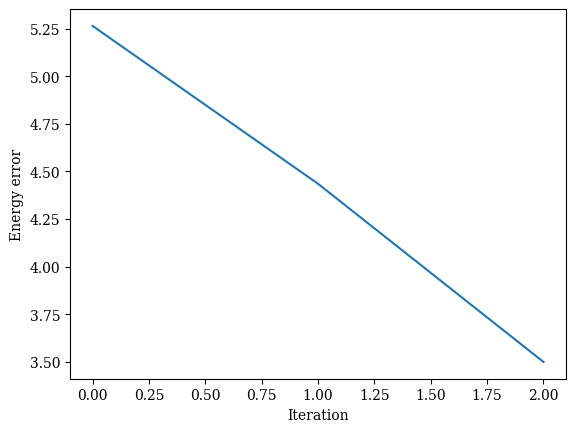

In [7]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [8]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Carry out SQD.

In [9]:
# Use a fake computer to get noise.
computer = qiskit_ibm_runtime.fake_provider.FakeTorino()
simualtor = AerSimulator(method="matrix_product_state").from_backend(computer)
sampler = Sampler(simualtor)

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)


In [11]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'rz': 13, 'sx': 10, 'measure': 8, 'cz': 6, 'x': 4, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 24, 'sx': 18, 'cz': 10, 'measure': 8, 'x': 5, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 39, 'sx': 28, 'cz': 16, 'measure': 8, 'x': 6, 'barrier': 4})


In [12]:
energies = []
errors = []

for bit_array in bit_arrays:
    print(bit_array.num_bits)
    bit_matrix = bit_array.to_bool_array()
    print(bit_matrix.shape)
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

8
(30000, 8)
8
(30000, 8)
8
(30000, 8)


Text(0, 0.5, 'Energy error')

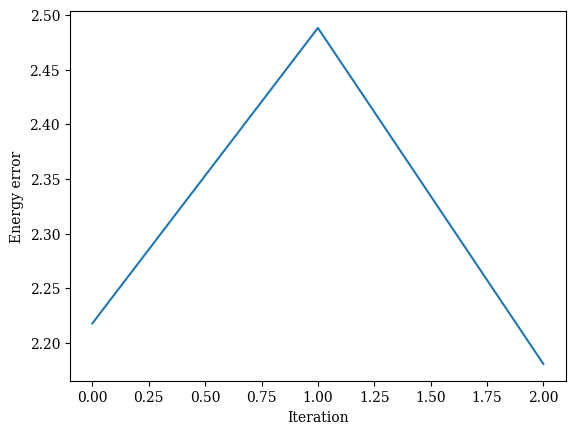

In [13]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [14]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

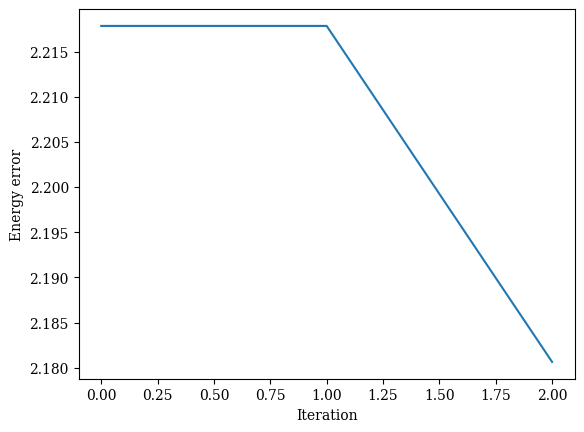

In [15]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Random sampling

Instead of sampling from an approximation of the ground state, make a truly random array of bits.

In [ ]:
from qiskit_addon_sqd.counts import generate_bit_array_uniform

bit_array = generate_bit_array_uniform(30_000, nq, rand_seed=1)

In [20]:
bit_matrix = bit_array.to_bool_array()
eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
min_energy_random = np.min(eigvals)
err_random = abs(min_energy - exact_energy)
rel_err_random = err_random / abs(exact_energy)

## Plot final results

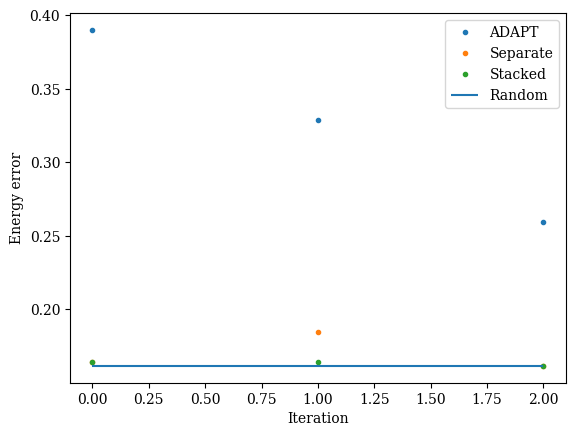

In [21]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.hlines(rel_err_random, 0., len(rel_errors) - 1, label="Random")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()